## Main Imports

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Data Preprocessing

In [78]:
df_train  = pd.read_csv("data/train.csv")
df_sample = pd.read_csv("data/sample_submission.csv")
df_test   = pd.read_csv("data/train.csv")

labels = ['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III' , 'Overweight_Level_I', 'Overweight_Level_II']

# drop id (not useful)
df_train.drop('id',axis=1,inplace=True)
df_test.drop('id',axis=1,inplace=True)

## Response Factory

In [79]:
import time

class Response:
  def __init__(self, predictions, features, predict_proba, start_time):
    self.predictions = predictions
    self.features = features
    self.predict_proba = predict_proba
    self.execution_time = time.time() - start_time
    
  def get_predictions(self): return self.predictions
  
  def get_features(self): return self.features
  
  def get_time(self): return self.execution_time
  
  def get_predict_proba(self): return self.predict_proba    

## Additional Features

In [80]:
df_train['BMI'] = (df_train['Weight'] / df_train['Height']**2)

In [81]:
numerical_cols   = df_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_cols = df_train.select_dtypes(include=[object]).columns.tolist()

num_numerical_cols = len(numerical_cols)
num_numerical_rows = num_numerical_cols // 4

num_categorical_cols = len(categorical_cols)
num_categorical_rows = num_categorical_cols // 4

## Data Spliting and Processing

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize

y = df_train['NObeyesdad']
x = df_train.copy().drop(columns=['NObeyesdad'])

categoricals_cols_no_result = [col for col in categorical_cols if col != "NObeyesdad"]
x = pd.get_dummies(x, columns=categoricals_cols_no_result, drop_first=True)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20)

y_test_bin = label_binarize(y_test, classes=labels)
n_classes = y_test_bin.shape[1]

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Duplicate and NA Count

In [83]:
# number of na
mv = df_train.isna().sum().sum()

# number of duplicates
dv = df_train.duplicated().sum()

# there are no NAs or Duplicates in the test dataset
print(mv)
print(dv)

0
0


## Features Distribution

In [84]:
display(df_train.describe(include=[np.number]).T, df_train.describe(include=[object]).T)

,count,mean,std,min,25%,50%,75%,max
Age,20758.0,23.841804,5.688072,14.000000,20.000000,22.815416,26.000000,61.000000
Height,20758.0,1.700245,0.087312,1.450000,1.631856,1.700000,1.762887,1.975663
Weight,20758.0,87.887768,26.379443,39.000000,66.000000,84.064875,111.600553,165.057269
FCVC,20758.0,2.445908,0.533218,1.000000,2.000000,2.393837,3.000000,3.000000
NCP,20758.0,2.761332,0.705375,1.000000,3.000000,3.000000,3.000000,4.000000
CH2O,20758.0,2.029418,0.608467,1.000000,1.792022,2.000000,2.549617,3.000000
FAF,20758.0,0.981747,0.838302,0.000000,0.008013,1.000000,1.587406,3.000000
TUE,20758.0,0.616756,0.602113,0.000000,0.000000,0.573887,1.000000,2.000000
BMI,20758.0,30.241842,8.333932,12.868541,24.088223,29.384757,37.011168,54.997991


,count,unique,top,freq
Gender,20758,2,Female,10422
family_history_with_overweight,20758,2,yes,17014
FAVC,20758,2,yes,18982
CAEC,20758,4,Sometimes,17529
SMOKE,20758,2,no,20513
SCC,20758,2,no,20071
CALC,20758,3,Sometimes,15066
MTRANS,20758,5,Public_Transportation,16687
NObeyesdad,20758,7,Obesity_Type_III,4046


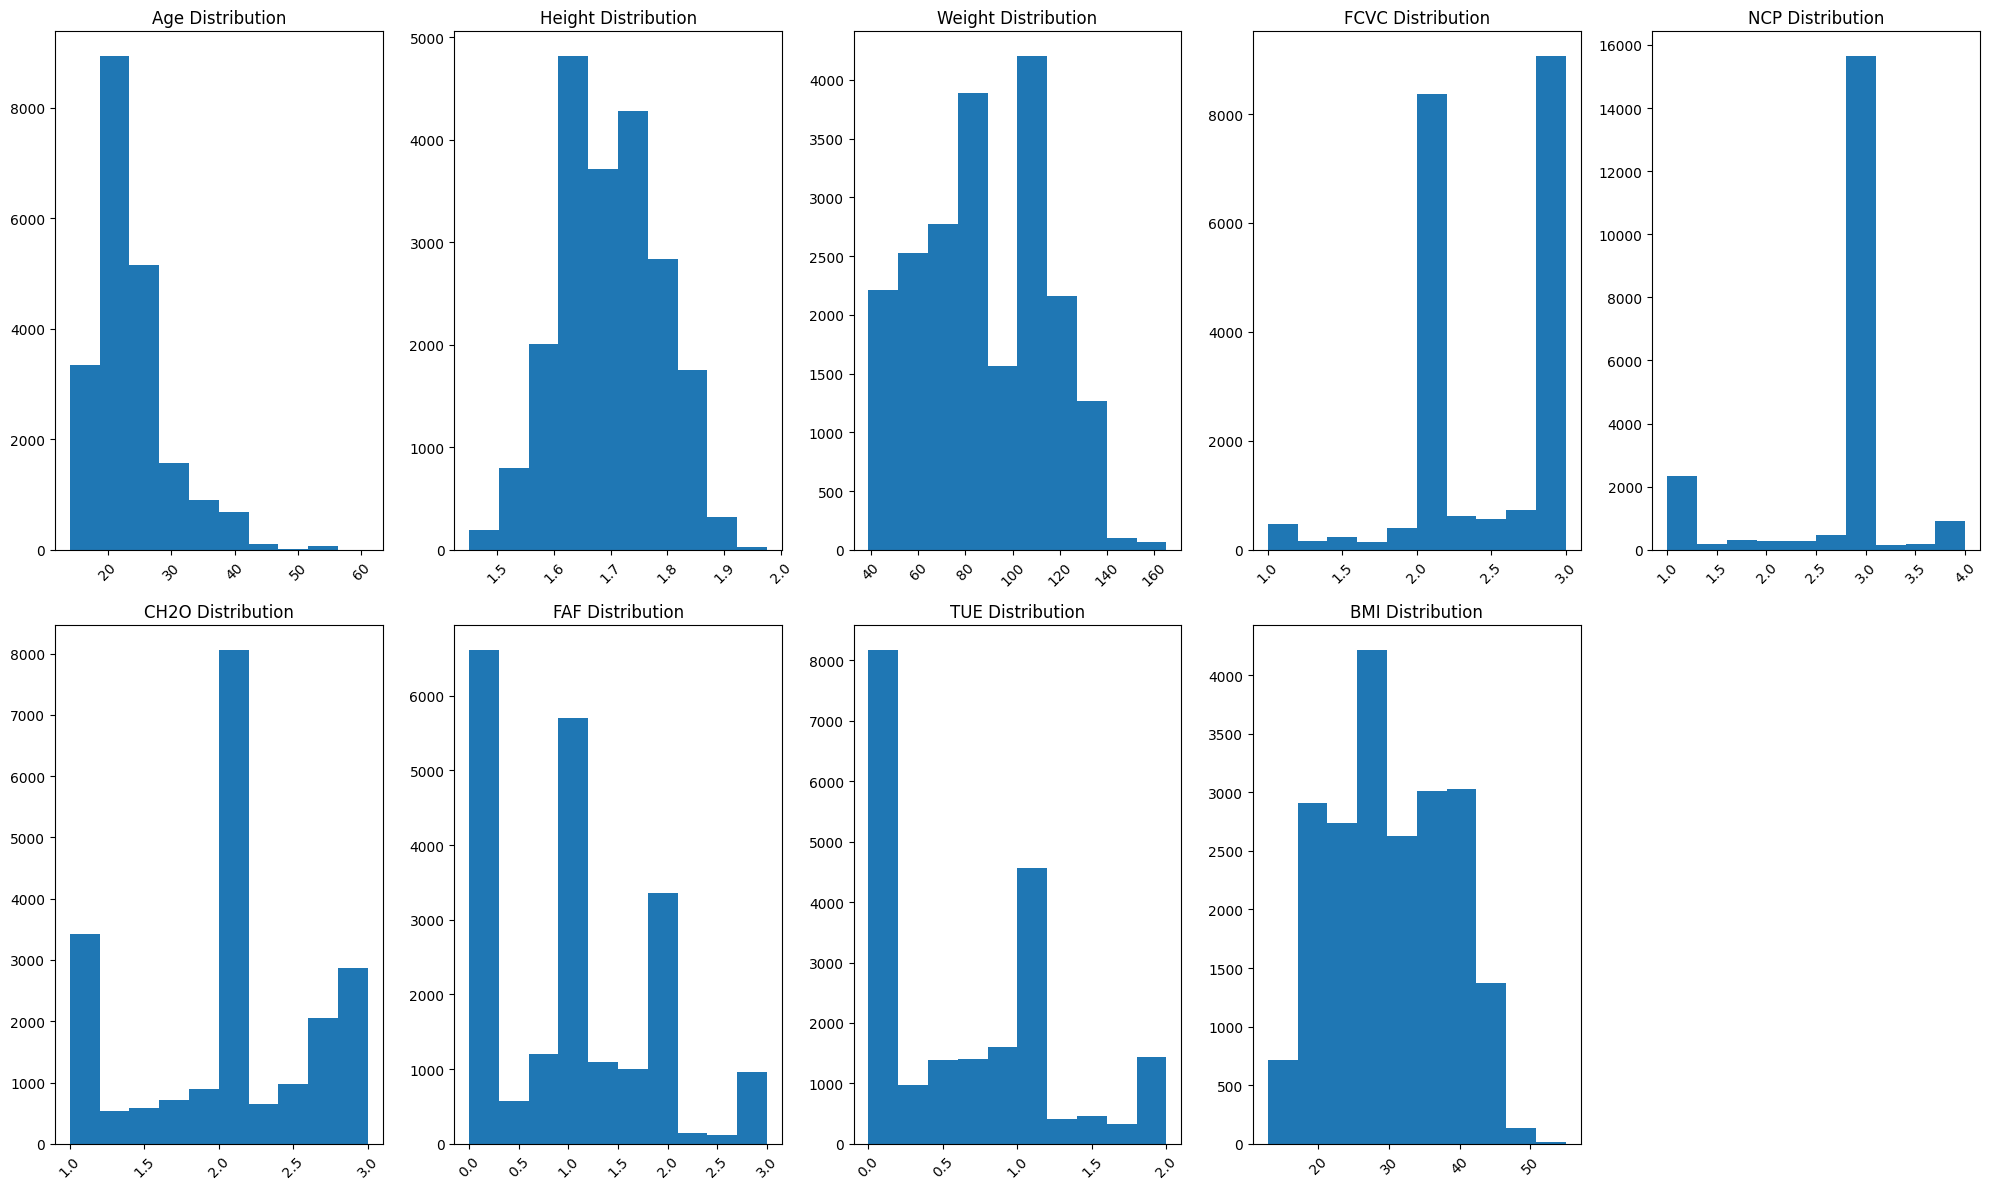

In [85]:
# numerical cols histogram
plt.figure(figsize=(20,6 * num_numerical_rows))
for i ,col in enumerate(numerical_cols,1):
    plt.subplot(num_numerical_rows, 5, i)
    plt.hist(df_train[col])
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 


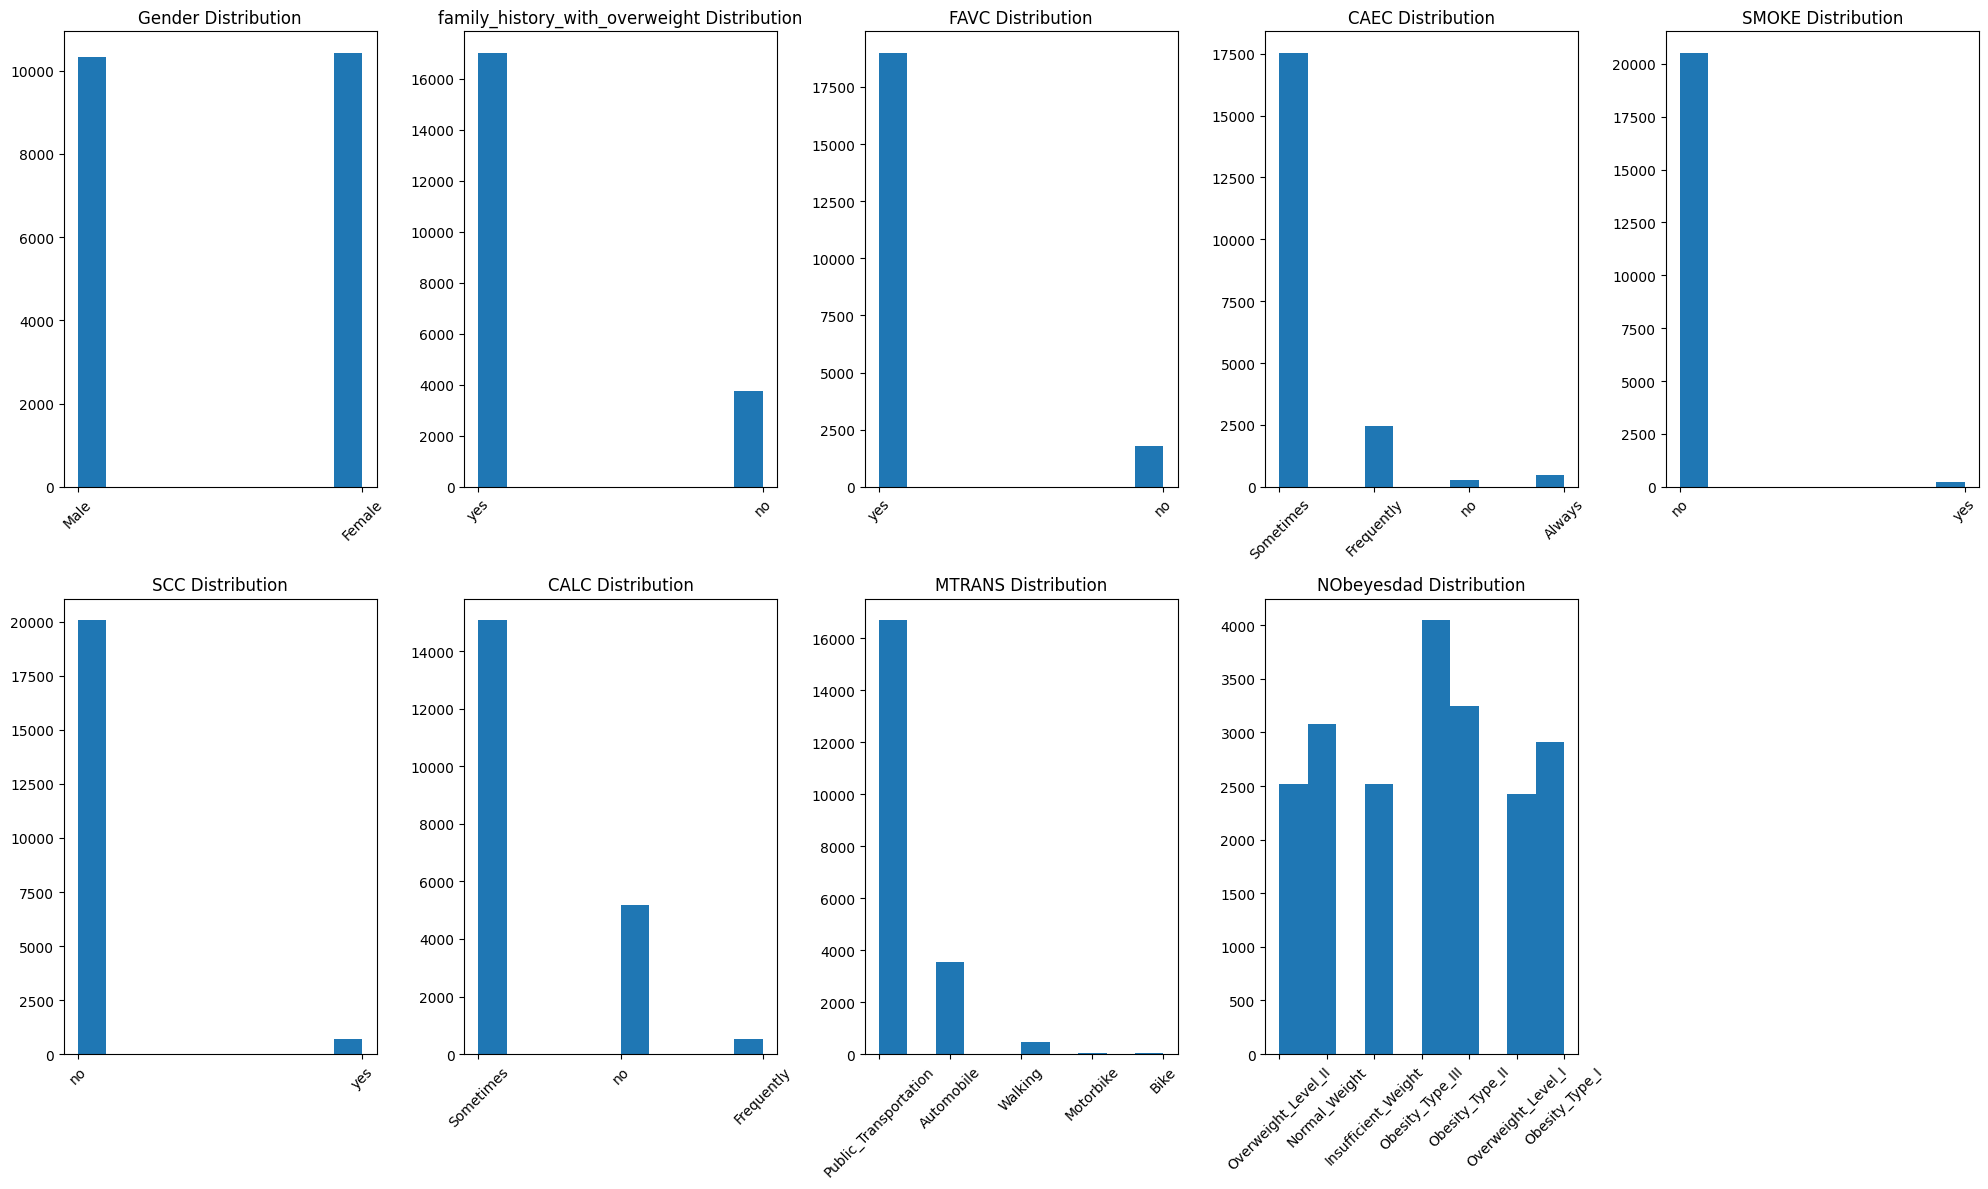

In [86]:
# categorical cols histogram
plt.figure(figsize=(20,6 * num_categorical_rows))
for i ,col in enumerate(categorical_cols,1):
    plt.subplot(num_categorical_rows, 5, i)
    plt.hist(df_train[col])
    plt.title(f'{col} Distribution')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 


## Feature Correlation

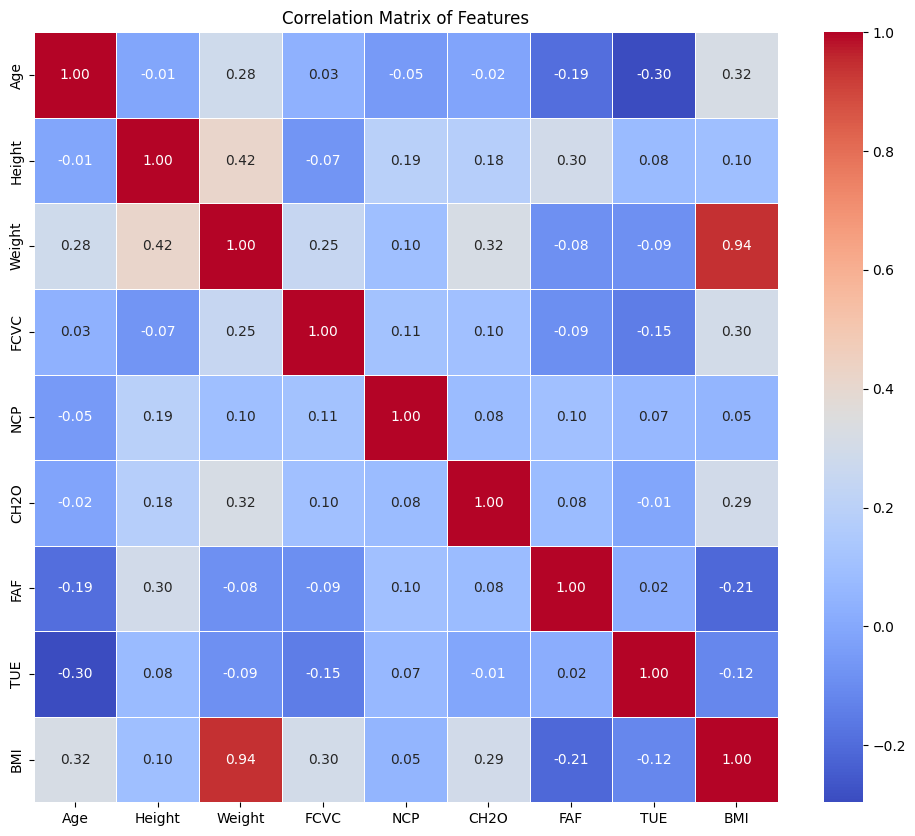

In [87]:
def corr(data):
    plt.figure(figsize=(12,10))
    sns.heatmap(data, annot=True, cmap='coolwarm', fmt='.2f', linewidths= 0.5)
    plt.title('Correlation Matrix of Features')
corr(df_train[numerical_cols].corr())

## Decision Tree

### Without FS

In [88]:
from sklearn.tree import DecisionTreeClassifier
import time

def decision_tree_wfs() -> Response:
  start = time.time()

  model = DecisionTreeClassifier(ccp_alpha=0.01)
  predictions = model.fit(x_train_scaled, y_train).predict(x_test_scaled)
  predicted_proba = model.predict_proba(x_test_scaled)

  return Response(predictions, [], predicted_proba, start)

  # feature_importance = pd.DataFrame(clf.feature_importances_, index = x.columns).sort_values(0, ascending=False)
  # feature_importance.head(10).plot(kind='bar')

### With FS

In [89]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import time

def decision_tree_fs() -> Response:
  start = time.time()
  
  clf = DecisionTreeClassifier(ccp_alpha=0.01)
  
  max_acc = 0
  max_features = x.shape[1]
  best_features_names = None
  best_predictions = None
  best_proba = None

  for i in range(1,max_features):
    rfe = RFE(estimator=clf, n_features_to_select=i).fit(x_train_scaled, y_train)

    selected_features = x_train.columns[rfe.support_]

    x_train_rfe = rfe.transform(x_train_scaled)
    x_test_rfe = rfe.transform(x_test_scaled)

    clf.fit(x_train_rfe, y_train)
    predictions = clf.predict(x_test_rfe)
    predicted_proba = clf.predict_proba(x_test_rfe)

    acc = accuracy_score(y_test, predictions)
    
    if(acc > max_acc): # From 3 features beyond the accuracy does not change
      max_acc = acc
      best_features_names = selected_features
      best_predictions = predictions
      best_proba = predicted_proba
    
  return Response(best_predictions, best_features_names, best_proba, start)

## K-Nearest-Neighbours

### Finding Optimal K

In [90]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.neighbors import KNeighborsClassifier
# from collections import defaultdict, Counter


# number_of_runs = 20
# number_of_neighbors = 25

# top_k_counts = Counter()
# k_accuracy_map = defaultdict(list)

# for run in range(1, number_of_runs + 1):
#     k_accuracies = []

#     for k in range(1, number_of_neighbors + 1):
#         knn = KNeighborsClassifier(n_neighbors=k)
#         knn.fit(x_train_scaled, y_train)
#         preds = knn.predict(x_test_scaled)
#         acc = accuracy_score(y_test, preds)
#         k_accuracies.append((k, acc))

#     k_accuracies.sort(key=lambda tup: tup[1], reverse=True)
    
#     for i, (k, acc) in enumerate(k_accuracies):
#         k_accuracy_map[k].append(acc)
#         if i == 0:
#             top_k_counts[k] += 1

#     best_k, best_acc = k_accuracies[0]

# avg_accuracies = {k: np.mean(accs) for k, accs in k_accuracy_map.items()}
# sorted_avg = sorted(avg_accuracies.items(), key=lambda x: x[1], reverse=True)

# best_avg_k, best_avg_acc = sorted_avg[0]
# print(f"\nBest k by average accuracy: k = {best_avg_k}\n")

# ks = sorted(avg_accuracies.keys())
# accs = [avg_accuracies[k] for k in ks]

# plt.figure(figsize=(10, 6))
# plt.plot(ks, accs, marker='o')
# plt.title("Average Accuracy for each k")
# plt.xlabel("k")
# plt.ylabel("Average Accuracy")
# plt.grid(True)
# plt.tight_layout()
# plt.show()


### Without FS

In [91]:
from sklearn.neighbors import KNeighborsClassifier
import time

def knn_wfs(num_neighbours) -> Response:
  start = time.time()
  
  model = KNeighborsClassifier(n_neighbors=num_neighbours)
  model.fit(x_train_scaled, y_train)
  predictions = model.predict(x_test_scaled)
  predicted_proba = model.predict_proba(x_test_scaled)
  
  return Response(predictions, [], predicted_proba, start)

### With FS

In [92]:
from sklearn.feature_selection import SelectKBest, f_classif
import time

def knn_fs(neighbour_number) -> Response:
  start = time.time()
  
  max_acc = 0
  max_features = x.shape[1]
  best_features_names = None
  best_predictions = None
  best_proba = None
  
  knn = KNeighborsClassifier(n_neighbors=neighbour_number)

  for i in range(1, max_features):
    selector = SelectKBest(score_func=f_classif, k=i)
    x_train_selected = selector.fit_transform(x_train_scaled, y_train)
    x_test_selected = selector.transform(x_test_scaled)
    
    selected_features = x_train.columns[selector.get_support()]

    knn.fit(x_train_selected, y_train)

    predictions = knn.predict(x_test_selected)
    predicted_proba = knn.predict_proba(x_test_selected)
    acc = accuracy_score(y_test, predictions)

    if(acc > max_acc):
      max_acc = acc
      best_predictions = predictions
      best_features_names = selected_features
      best_proba = predicted_proba
      
  return Response(best_predictions, best_features_names, best_proba, start)

## Support Vector Machines

### Without FS

In [93]:
from sklearn.svm import SVC
import time

def svc_wfs() -> Response:
  start = time.time()
  model = SVC(probability=True)
  model.fit(x_train_scaled, y_train)
  predictions = model.predict(x_test_scaled)
  predicted_proba = model.predict_proba(x_test_scaled)

  return Response(predictions, [], predicted_proba, start)

### With FS

In [94]:
from sklearn.feature_selection import RFE
import time 

def svc_fs() -> Response:
  start = time.time()
  
  print("fitting")
  svc = SVC(kernel="linear", probability=True)
  print("fitted")
  
  max_acc = 0
  best_features_names = None
  max_features = x.shape[1]
  best_predictions = None
  best_proba = None

  for i in range(1,max_features):
    print("sfs")
    sfs = RFE(
        estimator=svc,
        n_features_to_select=i, 
        step=1
    ).fit(x_train_scaled, y_train)
    
    selected_features = x_train.columns[sfs.get_support()]
    print("Selected features: " + str(selected_features))
    
    x_train_sfs = sfs.transform(x_train_scaled)
    x_test_sfs = sfs.transform(x_test_scaled)

    svc.fit(x_train_sfs, y_train)

    predictions = svc.predict(x_test_sfs)
    predicted_proba = svc.predict_proba(x_test_sfs)
    acc = accuracy_score(y_test, predictions)

    if(acc > max_acc):
      max_acc = acc
      best_predictions = predictions
      best_features_names = selected_features
      best_proba = predicted_proba
      
  return Response(best_predictions, best_features_names, best_proba, start)

## Neural Networks

In [95]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import time

def neural_networks() -> Response:
    start = time.time()
    
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)

    model = MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',                    
        alpha=0.0001,                      
        batch_size='auto',
        learning_rate='adaptive',         
        max_iter=1000,                     
        early_stopping=True,               
        validation_fraction=0.2,          
        n_iter_no_change=10,          
    )
    
    model.fit(x_train_scaled, y_train_encoded)
    predictions_encoded = model.predict(x_test_scaled)
    predicted_proba = model.predict_proba(x_test_scaled)
    
    predictions = label_encoder.inverse_transform(predictions_encoded)

    return Response(predictions, [], predicted_proba, start)

## Ensemble

In [96]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

clf = DecisionTreeClassifier(ccp_alpha=0.01)
knn = KNeighborsClassifier(n_neighbors=6)
mlp = MLPClassifier(
    hidden_layer_sizes=(250, 150, 100),
    activation='relu',
    solver='adam',                    
    alpha=0.0001,                      
    batch_size='auto',
    learning_rate='adaptive',         
    max_iter=1000,                     
    early_stopping=True,               
    validation_fraction=0.2,          
    n_iter_no_change=10,          
)
svc = SVC()

ensemble = VotingClassifier(estimators=[("clf", clf), ("knn", knn), ("mlp", mlp), ("svc", svc)], voting="hard")

ensemble.fit(x_train_scaled, y_train)
print(f"Accuracy of the ensemble: {round(ensemble.score(x_test_scaled, y_test)*100, 2)} %")

Accuracy of the ensemble: 87.09 %


## Metrics

### Metrics Processing

In [97]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt
import pandas as pd

def get_model_metrics(response, model_name):
    predictions = response.get_predictions()
    return {
        'Model': model_name,
        'Accuracy': round(accuracy_score(y_test, predictions) * 100, 2),
        'Precision': round(precision_score(y_test, predictions, average="macro") * 100, 2),
        'Recall': round(recall_score(y_test, predictions, average='macro') * 100, 2),
        'F1-Score': round(f1_score(y_test, predictions, average='macro') * 100, 2),
        'Time (s)': round(response.get_time(), 2),
        'Features': len(response.get_features()) if len(response.get_features()) else 'All'
    }

def run_model(model_func, model_name, *args):
    print("Running " + model_name)
    return model_func(*args)

models = {}
model_functions = [
    ('Decision Tree (No FS)', decision_tree_wfs, []),
    ('Decision Tree (FS)', decision_tree_fs, []),
    ('KNN (No FS)', knn_wfs, [8]),
    ('KNN (FS)', knn_fs, [8]),
    ('SVM (No FS)', svc_wfs, []),
    # ('SVM (FS)', svc_fs, []),
    ('Neural Network', neural_networks, [])
]

for model_name, model_func, args in model_functions:
    result = run_model(model_func, model_name, *args)
    if result is not None:
        models[model_name] = result

Running Decision Tree (No FS)
Running Decision Tree (FS)
Running KNN (No FS)
Running KNN (FS)
Running SVM (No FS)
Running Neural Network


### Table Comparison

In [98]:
if models:
    metrics = []
    for model_name, response in models.items():
        metrics.append(get_model_metrics(response, model_name))

    table = pd.DataFrame(metrics)
    print(table.to_string(index=False))

                Model  Accuracy  Precision  Recall  F1-Score  Time (s) Features
Decision Tree (No FS)     83.74      82.19   82.07     82.05      0.15      All
   Decision Tree (FS)     83.74      82.19   82.07     82.05     19.45        3
          KNN (No FS)     77.48      74.54   74.67     74.49      0.45      All
             KNN (FS)     86.75      85.15   85.11     85.12     10.23        5
          SVM (No FS)     85.98      84.18   84.18     84.17      9.75      All
       Neural Network     86.25      84.52   84.51     84.43      0.71      All


### Confusion Matrices Comparison

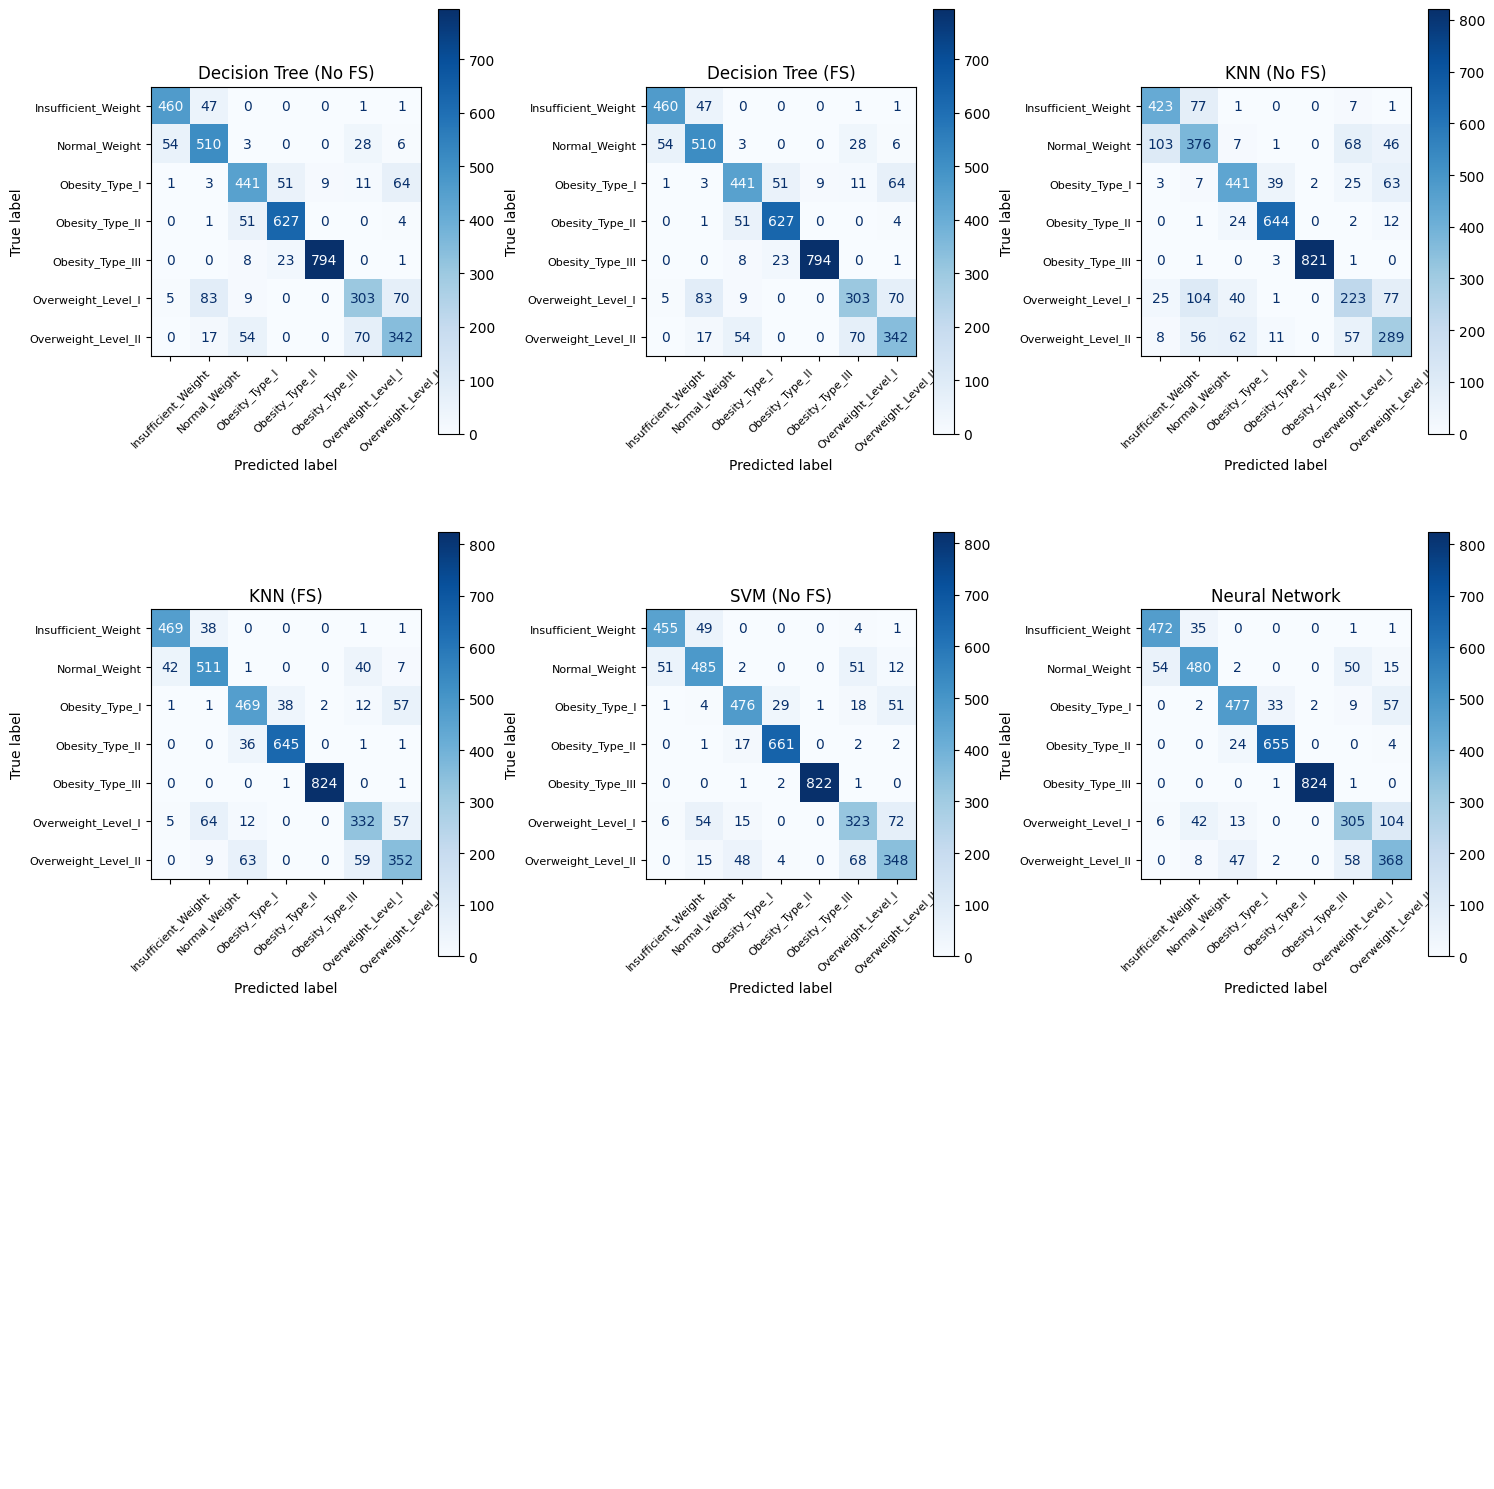

In [99]:
from sklearn.metrics import ConfusionMatrixDisplay

if models:
    cols = 3
    rows = 3
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    axes = axes.flatten()

    for i, (model_name, response) in enumerate(models.items()):
        if i < len(axes):
            cm = confusion_matrix(y_test, response.get_predictions(), labels=labels)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
            disp.plot(ax=axes[i], cmap='Blues', values_format='d')
            axes[i].set_title(model_name, fontsize=12)
            axes[i].tick_params(axis='x', rotation=45, labelsize=8)
            axes[i].tick_params(axis='y', labelsize=8)

    for i in range(len(models), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

### Learning Curves

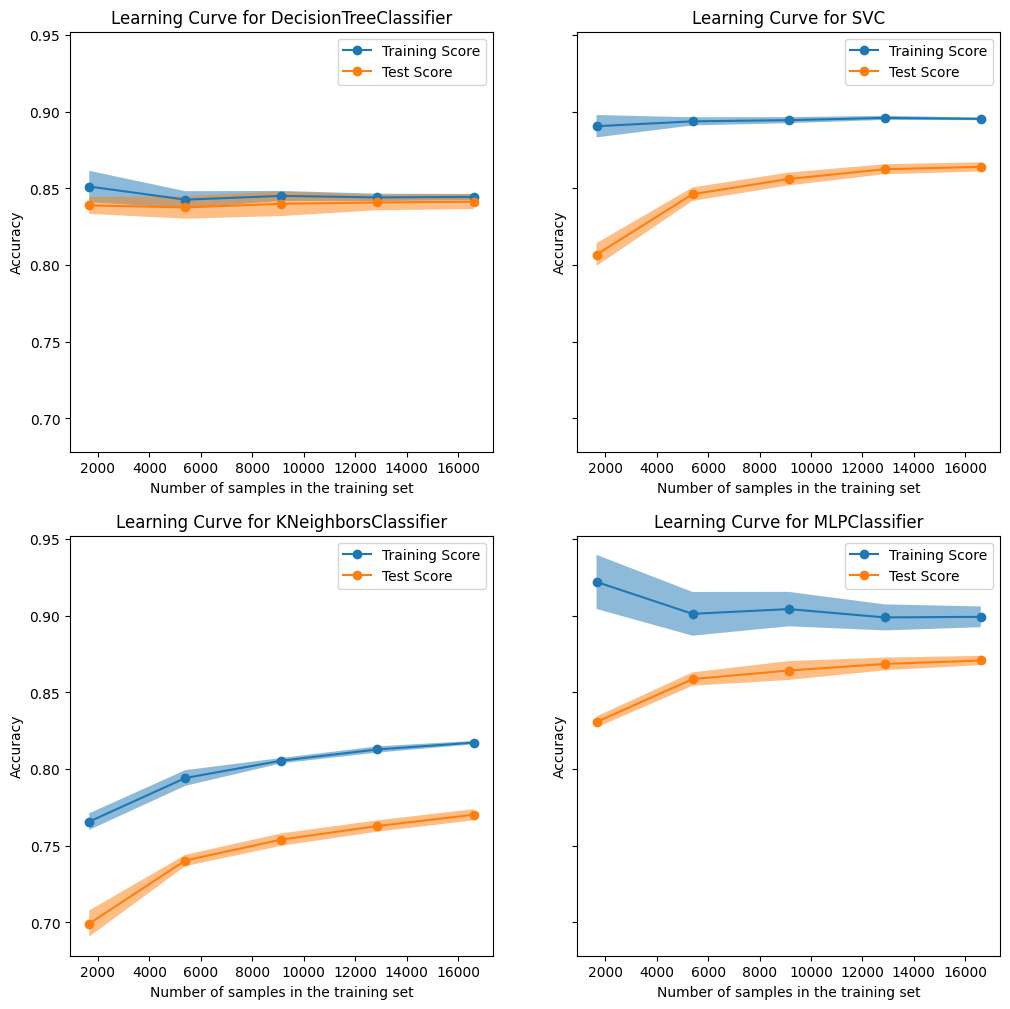

In [100]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12), sharey=True)
ax = axes.flatten()

label_encoder = LabelEncoder()
scaler = StandardScaler()

new_x = scaler.fit_transform(x)
new_y = label_encoder.fit_transform(y)

common_params = {
    "X": new_x,
    "y": new_y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

clf = DecisionTreeClassifier(ccp_alpha=0.01)
svc = SVC()
knn = KNeighborsClassifier(n_neighbors=8)
nn = MLPClassifier(
    hidden_layer_sizes=(250, 150, 100),
    activation='relu',
    solver='adam',                    
    alpha=0.0001,                      
    batch_size='auto',
    learning_rate='adaptive',         
    max_iter=1000,                     
    early_stopping=True,               
    validation_fraction=0.2,          
    n_iter_no_change=10,          
)


for ax_idx, estimator in enumerate([clf, svc,knn,nn]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:4], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

### ROC Curves Comparison

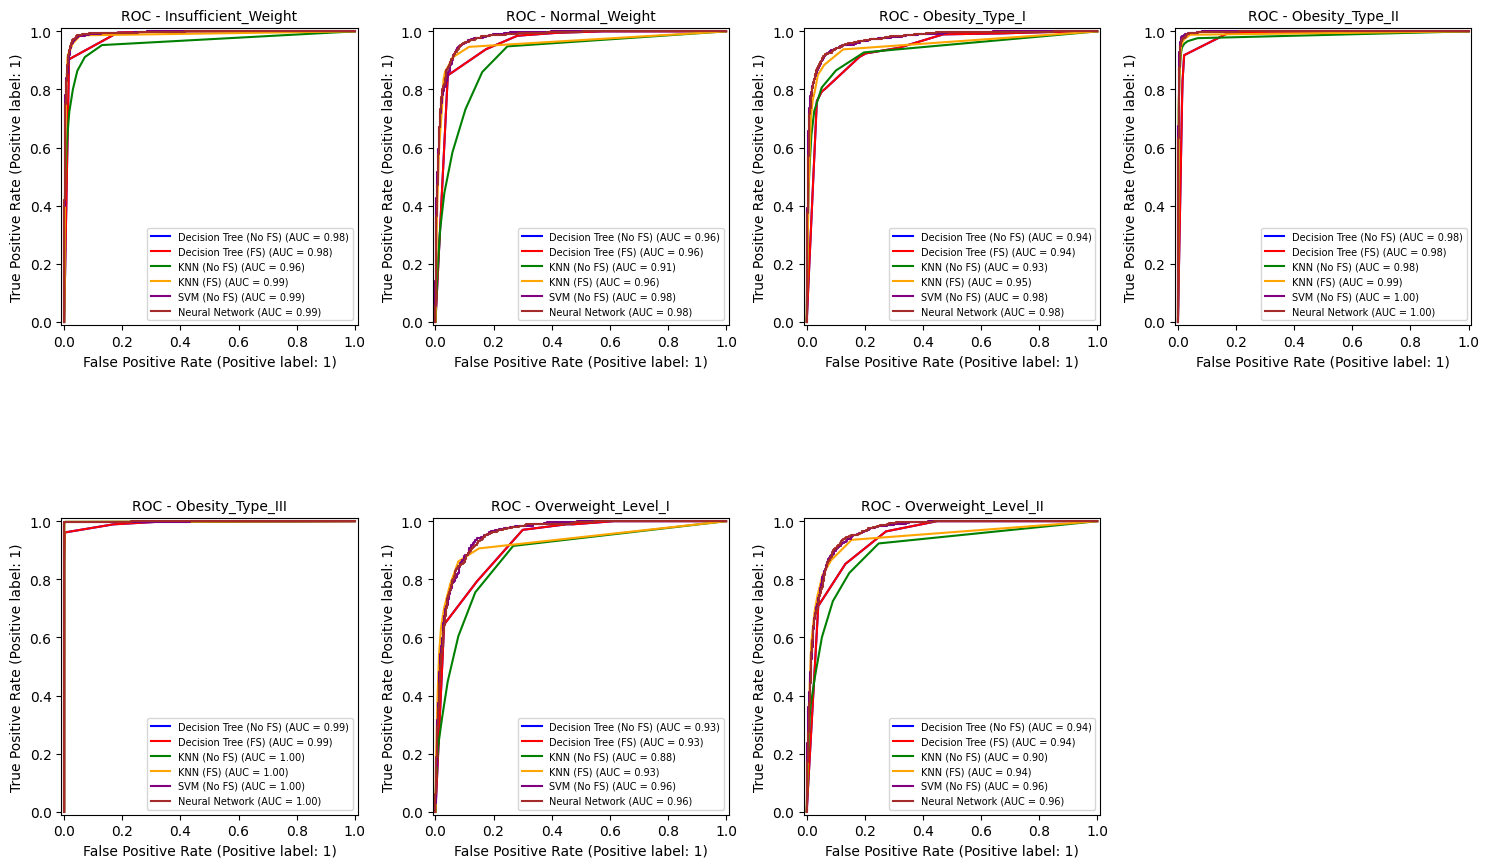

In [101]:
if models:
    plt.figure(figsize=(15, 10))
    
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink']
    
    for i in range(n_classes):
        plt.subplot(2, 4, i + 1)
        
        for j, (model_name, response) in enumerate(models.items()):        
            RocCurveDisplay.from_predictions(
                y_test_bin[:, i],
                response.get_predict_proba()[:, i],
                name=model_name,
                color=colors[j % len(colors)],
                ax=plt.gca()
            )
        
        plt.title("ROC - " + labels[i], fontsize=10)
        plt.legend(fontsize=7, loc='lower right')
    
    plt.tight_layout()
    plt.show()

### Validation Curves Comparison

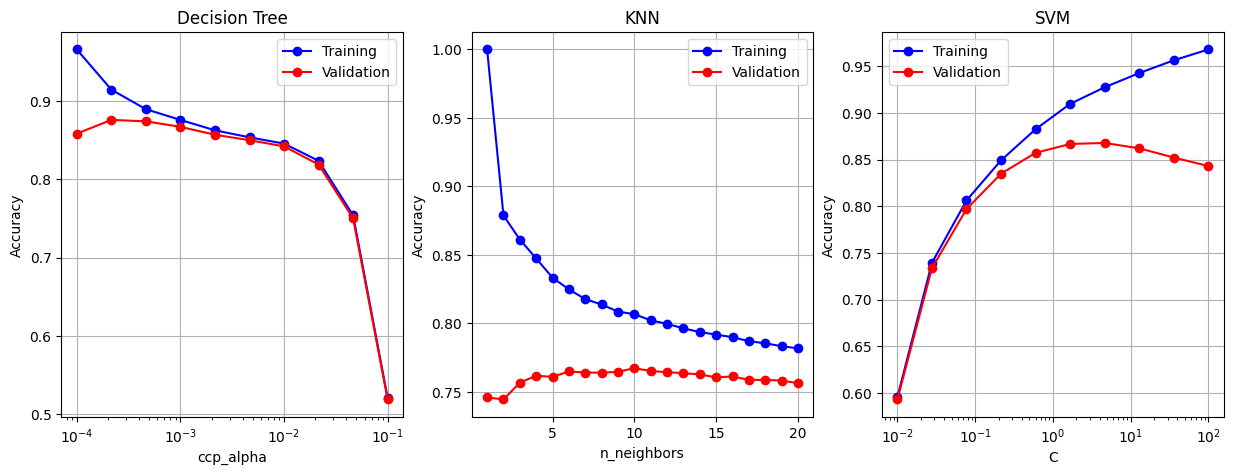

In [102]:
from sklearn.model_selection import validation_curve

def plot_validation_curves():
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    param_range = np.logspace(-4, -1, 10)
    train_scores, val_scores = validation_curve(
        DecisionTreeClassifier(ccp_alpha=0.01), x_train_scaled, y_train,
        param_name='ccp_alpha', param_range=param_range,
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    
    axes[0].semilogx(param_range, train_mean, 'o-', color='blue', label='Training')
    axes[0].semilogx(param_range, val_mean, 'o-', color='red', label='Validation')
    axes[0].set_title('Decision Tree')
    axes[0].set_xlabel('ccp_alpha')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    param_range = range(1, 21)
    train_scores, val_scores = validation_curve(
        KNeighborsClassifier(n_neighbors=8), x_train_scaled, y_train,
        param_name='n_neighbors', param_range=param_range,
        cv=5, scoring='accuracy', n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    
    axes[1].plot(param_range, train_mean, 'o-', color='blue', label='Training')
    axes[1].plot(param_range, val_mean, 'o-', color='red', label='Validation')
    axes[1].set_title('KNN')
    axes[1].set_xlabel('n_neighbors')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    param_range = np.logspace(-2, 2, 10)
    train_scores, val_scores = validation_curve(
        SVC(), x_train_scaled, y_train,
        param_name='C', param_range=param_range,
        cv=3, scoring='accuracy', n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    
    axes[2].semilogx(param_range, train_mean, 'o-', color='blue', label='Training')
    axes[2].semilogx(param_range, val_mean, 'o-', color='red', label='Validation')
    axes[2].set_title('SVM')
    axes[2].set_xlabel('C')
    axes[2].set_ylabel('Accuracy')
    axes[2].legend()
    axes[2].grid(True)
    
plot_validation_curves()

### Feature Usage

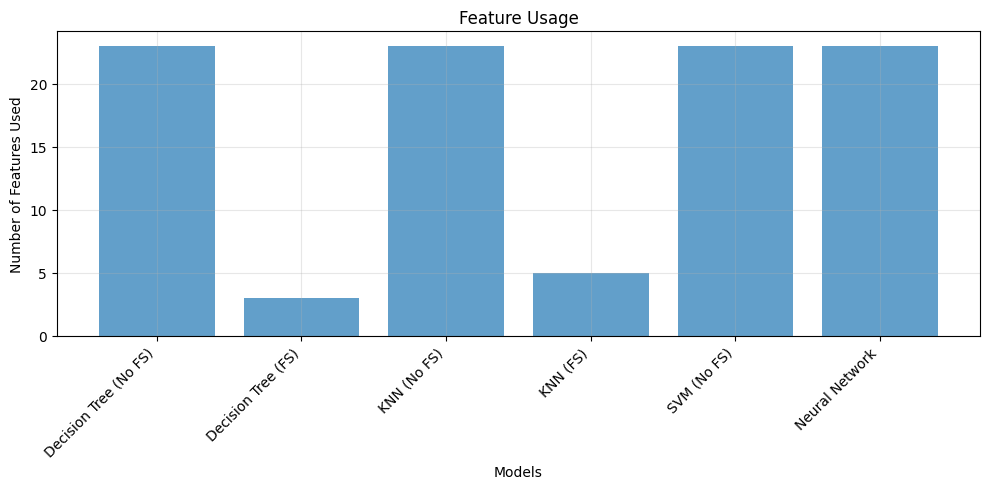

In [103]:
def plot_model_comparison():    
    _, axes = plt.subplots(1, 1, figsize=(10, 5))

    feature_counts = []
    model_names_features = []
    for model_name, response in models.items():
        features = response.get_features()
        if len(features) > 0:
            feature_counts.append(len(features))
            model_names_features.append(model_name)
        else:
            feature_counts.append(len(x_train.columns))
            model_names_features.append(model_name)
    
    axes.bar(range(len(feature_counts)), feature_counts, alpha=0.7)
    axes.set_xlabel('Models')
    axes.set_ylabel('Number of Features Used')
    axes.set_title('Feature Usage')
    axes.set_xticks(range(len(model_names_features)))
    axes.set_xticklabels(model_names_features, rotation=45, ha='right')
    axes.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
plot_model_comparison()

### Overfitting Analysis

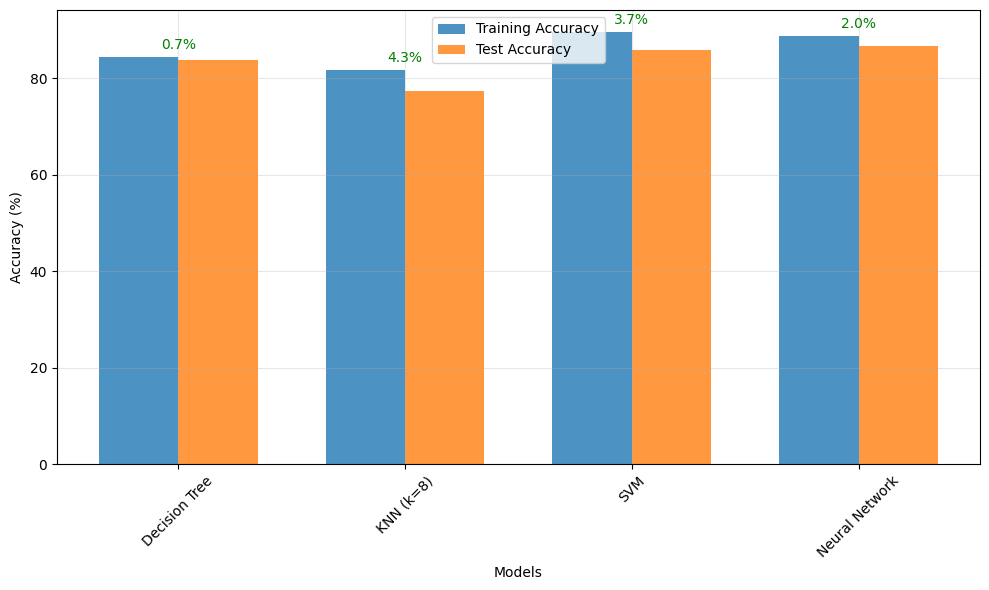

In [104]:
from sklearn.preprocessing import LabelEncoder

def analyze_model_complexity():
    complexity_models = {
        'Decision Tree': DecisionTreeClassifier(ccp_alpha=0.01),
        'KNN (k=8)': KNeighborsClassifier(n_neighbors=8),
        'SVM': SVC(probability=True),
        'Neural Network': MLPClassifier(
            hidden_layer_sizes=(250, 150, 100),
            activation='relu',
            solver='adam',                    
            alpha=0.0001,                      
            batch_size='auto',
            learning_rate='adaptive',         
            max_iter=1000,                     
            early_stopping=True,               
            validation_fraction=0.2,          
            n_iter_no_change=10,          
        )
    }
    
    train_accuracies = []
    test_accuracies = []
    model_names = []
    
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    for name, model in complexity_models.items():        
        if name == 'Neural Network':
            model.fit(x_train_scaled, y_train_encoded)
            train_acc = model.score(x_train_scaled, y_train_encoded)
            test_acc = model.score(x_test_scaled, y_test_encoded)
        else:
            model.fit(x_train_scaled, y_train)
            train_acc = model.score(x_train_scaled, y_train)
            test_acc = model.score(x_test_scaled, y_test)
        
        train_accuracies.append(train_acc * 100)
        test_accuracies.append(test_acc * 100)
        model_names.append(name)
    
    if train_accuracies and test_accuracies:
        plt.figure(figsize=(10, 6))
        
        x_pos = np.arange(len(model_names))
        width = 0.35
        
        plt.bar(x_pos - width/2, train_accuracies, width, label='Training Accuracy', alpha=0.8)
        plt.bar(x_pos + width/2, test_accuracies, width, label='Test Accuracy', alpha=0.8)
        
        plt.xlabel('Models')
        plt.ylabel('Accuracy (%)')
        plt.xticks(x_pos, model_names, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        for i, (train, test) in enumerate(zip(train_accuracies, test_accuracies)):
            gap = train - test
            plt.annotate(f'{gap:.1f}%', 
                xy=(i, max(train, test) + 1), 
                ha='center', va='bottom', fontsize=10,
                color='red' if gap > 10 else 'orange' if gap > 5 else 'green')
        
        plt.tight_layout()
        plt.show()
        
analyze_model_complexity()